<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [5]:
#df=pd.read_excel("BG_Dataset/BG_sample27.xlsx")

In [6]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample14.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [7]:
df.shape

(1155, 14)

In [8]:
df.head(13)

,색인,타임스탬프(YYYY-MM-DDThh:mm:ss),이벤트 유형,이벤트 하위 유형,환자 정보,장치 정보,소스 장치 ID,포도당 값 (mg/dL),인슐린 값(u),탄수화물 값 (그램),기간(hh:mm:ss),포도당 변화율 (mg/dL/min),트랜스미터 시간 (배장 정수),트랜스미터 ID
0,1,NaN,이름,NaN,sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,성,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,생년월일,NaN,1983-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,장치,NaN,NaN,Dexcom G5 Mobile App,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,경고,하락,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,6,NaN,경고,높음,NaN,NaN,Android,250.0,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,경고,낮음,NaN,NaN,Android,70.0,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,경고,신호 손실,NaN,NaN,Android,NaN,NaN,NaN,00:30:00,NaN,NaN,NaN
8,9,NaN,경고,상승,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,10,NaN,경고,긴급하게 낮음,NaN,NaN,Android,55.0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [10]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [11]:
df['Event'].value_counts()

EGV     1117
인슐린       12
교정         9
탄수화물       7
경고         6
생년월일       1
장치         1
성          1
이름         1
Name: Event, dtype: int64

In [12]:
df['Glucose'].value_counts()

99.0     16
129.0    14
134.0    14
97.0     13
153.0    13
         ..
271.0     1
227.0     1
185.0     1
270.0     1
277.0     1
Name: Glucose, Length: 209, dtype: int64

In [13]:
df.tail()

,Timestamp,Event,Glucose,Insulin,Meal
1150,2020-01-24T13:52:10,EGV,182.0,NaN,NaN
1151,2020-01-24T13:57:10,EGV,175.0,NaN,NaN
1152,2020-01-24T14:02:10,EGV,170.0,NaN,NaN
1153,2020-01-24T14:07:10,EGV,167.0,NaN,NaN
1154,2020-01-24T14:12:10,EGV,151.0,NaN,NaN


In [14]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

0.0     8
44.0    2
20.0    1
52.0    1
Name: Insulin, dtype: int64

In [15]:
# 식사 횟수
df['Meal'].value_counts()

0.0      5
200.0    1
100.0    1
Name: Meal, dtype: int64

In [16]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,NaN,이름,NaN,NaN,NaN
1,NaN,성,NaN,NaN,NaN
2,NaN,생년월일,NaN,NaN,NaN
3,NaN,장치,NaN,NaN,NaN
4,NaN,경고,NaN,NaN,NaN
5,NaN,경고,250.0,NaN,NaN
6,NaN,경고,70.0,NaN,NaN
7,NaN,경고,NaN,NaN,NaN
8,NaN,경고,NaN,NaN,NaN
9,NaN,경고,55.0,NaN,NaN


In [17]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [18]:
df.head(20)

,Timestamp,Event,Glucose,Insulin,Meal
10,2020-01-20T15:41:13,교정,139.0,NaN,NaN
11,2020-01-20T15:58:23,교정,135.0,NaN,NaN
12,2020-01-20T16:02:23,EGV,123.0,NaN,NaN
13,2020-01-20T16:07:15,EGV,112.0,NaN,NaN
14,2020-01-20T16:12:15,EGV,103.0,NaN,NaN
15,2020-01-20T16:17:16,EGV,105.0,NaN,NaN
16,2020-01-20T16:22:15,EGV,111.0,NaN,NaN
17,2020-01-20T16:27:15,EGV,133.0,NaN,NaN
18,2020-01-20T16:32:16,EGV,139.0,NaN,NaN
19,2020-01-20T16:37:15,EGV,150.0,NaN,NaN


In [19]:
df.shape

(1145, 5)

In [20]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [21]:
df.head(15)

,Timestamp,Event,Glucose,Insulin,Meal
0,2020-01-20T15:41:13,교정,139.0,NaN,NaN
1,2020-01-20T15:58:23,교정,135.0,NaN,NaN
2,2020-01-20T16:02:23,EGV,123.0,NaN,NaN
3,2020-01-20T16:07:15,EGV,112.0,NaN,NaN
4,2020-01-20T16:12:15,EGV,103.0,NaN,NaN
5,2020-01-20T16:17:16,EGV,105.0,NaN,NaN
6,2020-01-20T16:22:15,EGV,111.0,NaN,NaN
7,2020-01-20T16:27:15,EGV,133.0,NaN,NaN
8,2020-01-20T16:32:16,EGV,139.0,NaN,NaN
9,2020-01-20T16:37:15,EGV,150.0,NaN,NaN


In [22]:
df.shape

(1145, 5)

In [23]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [24]:
def isNaN(num):
    return num==num

In [25]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [26]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [27]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [28]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [29]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [30]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [31]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [32]:
glucose_count_high(df,'Glucose')

높음 :  0


In [33]:
print('높음 개수 :',len(high_list))

높음 개수 : 0


In [34]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [35]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [36]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [37]:
low_list

[]

In [38]:
calibration_count_low(df,'Event')

교정 :  9


In [39]:
calib_list

[0, 1, 60, 175, 360, 468, 757, 932, 1023]

In [40]:
insul_count(df,'Insulin')

인슐린 :  12


In [41]:
insulin_list

[26, 257, 258, 495, 554, 620, 771, 837, 889, 1052, 1060, 1119]

In [42]:
meal_count(df,'Meal')

식사 횟수 :  7


In [43]:
meal_list

[24, 249, 259, 321, 488, 890, 1061]

In [44]:
df['Insulin'].value_counts()

0.0     8
44.0    2
20.0    1
52.0    1
Name: Insulin, dtype: int64

In [45]:
df['Meal'].value_counts()

0.0      5
200.0    1
100.0    1
Name: Meal, dtype: int64

In [46]:
isNaN(df['Glucose'][14])

True

In [47]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [48]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [49]:
import math
math.isnan(df['Glucose'][14])

False

In [50]:
insulin_list

[26, 257, 258, 495, 554, 620, 771, 837, 889, 1052, 1060, 1119]

In [51]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [52]:
insulin_list

[26,
 257,
 258,
 495,
 554,
 620,
 771,
 837,
 889,
 1052,
 1060,
 1119,
 321,
 259,
 1061,
 488,
 24,
 249,
 890]

In [53]:
df=df.drop(insulin_list)

In [54]:
df[10:20]

,Timestamp,Event,Glucose,Insulin,Meal
10,2020-01-20T16:42:16,EGV,155.0,NaN,NaN
11,2020-01-20T16:47:16,EGV,139.0,NaN,NaN
12,2020-01-20T16:52:16,EGV,134.0,NaN,NaN
13,2020-01-20T16:57:16,EGV,137.0,NaN,NaN
14,2020-01-20T17:02:16,EGV,150.0,NaN,NaN
15,2020-01-20T17:07:16,EGV,154.0,NaN,NaN
16,2020-01-20T17:12:16,EGV,157.0,NaN,NaN
17,2020-01-20T17:17:16,EGV,159.0,NaN,NaN
18,2020-01-20T17:22:16,EGV,172.0,NaN,NaN
19,2020-01-20T17:27:16,EGV,183.0,NaN,NaN


In [55]:
df['Glucose'].unique()

array([139., 135., 123., 112., 103., 105., 111., 133., 150., 155., 134.,
       137., 154., 157., 159., 172., 183., 191., 198., 200., 196., 205.,
       225., 238., 236., 237., 239., 233., 248., 257., 262., 259., 254.,
       244., 228., 222., 213., 206., 194., 188., 177., 167., 163., 165.,
       162., 147., 143., 142., 140., 144., 146., 148., 149., 141., 122.,
       129., 145., 166., 171., 176., 193., 192., 208., 240., 246., 251.,
       256., 260., 263., 265., 250., 243., 241., 253., 252., 232., 229.,
       221., 210., 197., 266., 264., 258., 247., 218., 214., 216., 215.,
       212., 209., 207., 204., 190., 226., 261., 170., 156., 152., 138.,
       136., 131., 128., 121., 114., 110., 109., 107., 104., 102.,  99.,
       101., 100.,  96.,  92.,  94.,  95.,  97.,  93.,  88.,  98., 126.,
       160., 173., 179., 158., 153., 132., 116.,  91.,  85.,  84.,  79.,
        78.,  80.,  76.,  73.,  70.,  75.,  83., 118., 113., 106.,  89.,
        77.,  69.,  67., 125.,  87.,  81.,  90., 11

In [56]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1115
Meal         1119
dtype: int64

In [57]:
df['Event'].value_counts()

EGV    1117
교정        9
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [58]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [59]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [60]:
fix_glucose_low(df,'Glucose')

In [61]:
fix_glucose(df,'Glucose')

In [62]:
df['Glucose'].value_counts()

99.0     16
134.0    14
129.0    14
133.0    13
97.0     13
         ..
279.0     1
271.0     1
266.0     1
235.0     1
277.0     1
Name: Glucose, Length: 208, dtype: int64

In [63]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1115
Meal         1119
dtype: int64

In [64]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [65]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [66]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [67]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [68]:
new_meal_list

[24, 247, 315, 481]

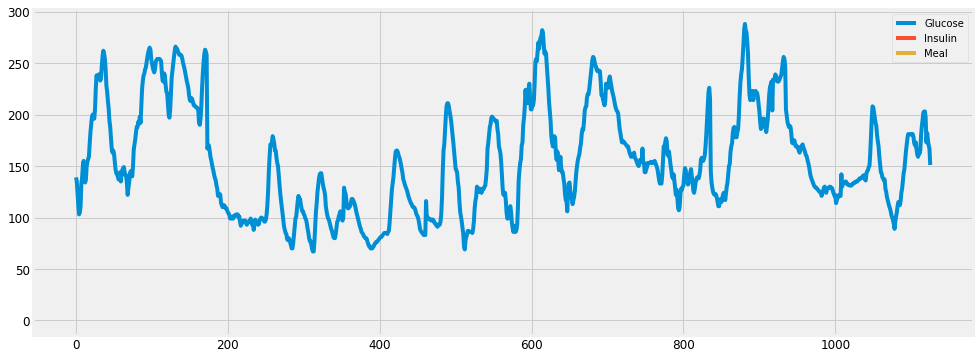

In [69]:
df.plot(figsize=(15,6))
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


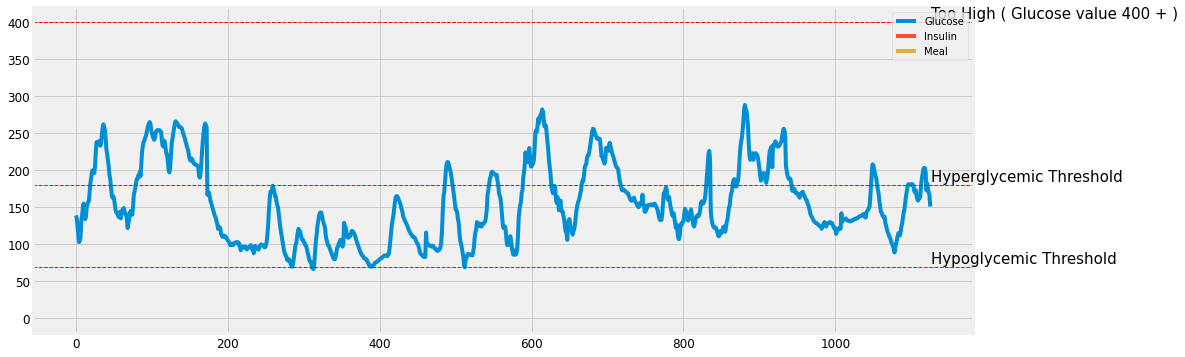

In [70]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [71]:
#df.drop(0,inplace=True)

In [72]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [73]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [74]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [75]:
#interpolate_glucose(df,'Glucose')

In [76]:
#meal

In [77]:
#insul

In [78]:
df['Glucose'].isnull().sum()

0

In [79]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [80]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [81]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [82]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


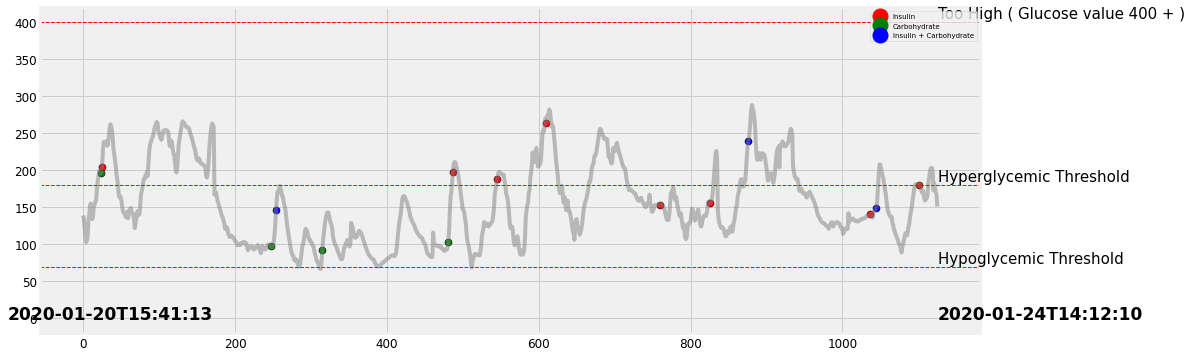

In [83]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [84]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [85]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [86]:
df[1900:1950]

,Timestamp,Event,Glucose,Insulin,Meal


In [87]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [88]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [89]:
import numpy as np
import tensorflow as tf
import random as rn

In [90]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [91]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [92]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [93]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

## 나이브 메소드

### 예를 들어 단순히 t 시점에 t - 6 (sampling rate가 5분이므로 30분), t + 1 시점에 t - 5값을 가져오는 naive한 방법

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
raw_seq = df['Glucose']
#raw_seq=raw_seq.to_numpy(dtype='int64')

In [96]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

### train

In [97]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)

In [98]:
TRAIN_SPLIT

788

In [99]:
train, test = train_test_split(raw_seq,train_size = TRAIN_SPLIT,shuffle=False,random_state=42)

In [100]:
#test[:5]

In [101]:
#raw_seq[731:740]

In [102]:
#test[:10]

In [103]:
train.shape

(788,)

#### 15 MIN

In [104]:
new_list = []
for i in range(len(train)):
  if i < 3:
    new_list.append(train[i])
  else:
    new_list.append(train[i-3])
  
  


  

In [105]:
#test =test.reset_index()

In [106]:
# 15분
RMSE(new_list,train)

16.470362553374287

#### 30 MIN

In [107]:
new_list = []
for i in range(len(train)):
  if i < 6:
    new_list.append(train[i])
  else:
    new_list.append(train[i-6])
  

In [108]:
# 30분
RMSE(new_list,train)

27.327655615169768

#### 60 MIN

In [109]:
new_list = []
for i in range(len(train)):
  if i < 12:
    new_list.append(train[i])
  else:
    new_list.append(train[i-12])
  

In [110]:
# 60분
RMSE(new_list,train)

43.22231809755104

In [111]:
df.shape

(1126, 5)

### test

In [112]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)

In [113]:
TRAIN_SPLIT

788

In [114]:
test.shape

(338,)

In [115]:
test2 = []
for i in range(len(test)):
  test2.append(test[i+len(train)])


#### 15 MIN

In [116]:
new_list = []
for i in range(len(test)):
  if i < 3:
    new_list.append(test2[i])
  else:
    new_list.append(test2[i-3])

In [117]:
#test =test.reset_index()
#new_list[:15]

In [118]:
#test2[:15]

In [119]:
# 15분
RMSE(new_list,test2)

17.052390555832314

#### 30 MIN

In [120]:
new_list = []
for i in range(len(test)):
  if i < 6:
    new_list.append(test2[i])
  else:
    new_list.append(test2[i-6])

In [121]:
# 30분
RMSE(new_list,test2)

26.315001233912728

#### 60 MIN

In [122]:
new_list = []
for i in range(len(test)):
  if i < 12:
    new_list.append(test2[i])
  else:
    new_list.append(test2[i-12])

In [123]:
# 60분
RMSE(new_list,test2)

37.1164009426414

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


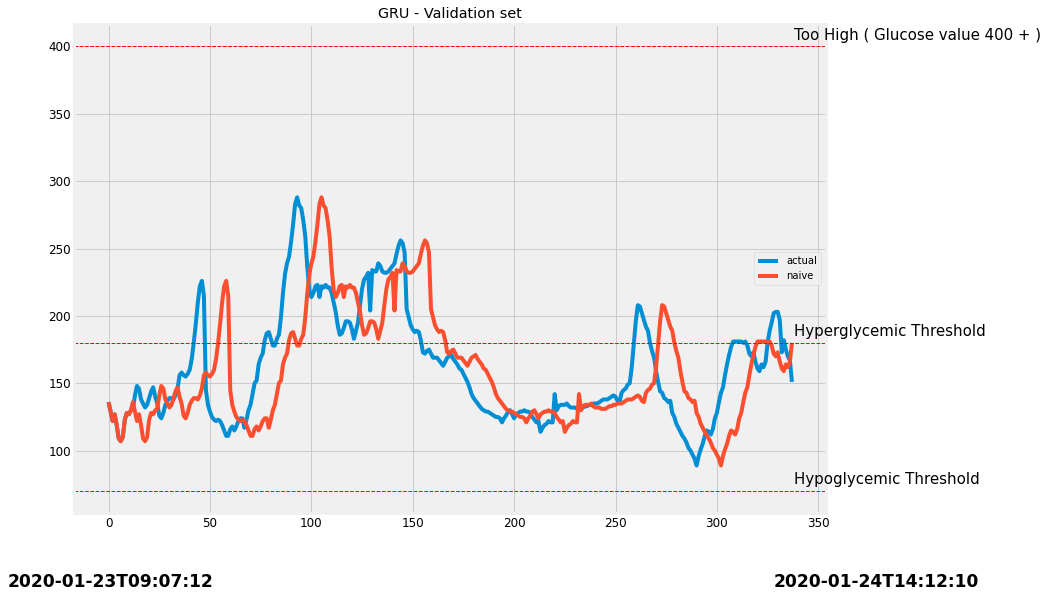

In [124]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(test2,label='actual')
plt.plot(new_list,label='naive')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(test),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(test),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(test),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()